## Overview of RC Model
---

This subsection describes the formulation of a physics-based model to simulate the thermal behaviour of the building using a resistor-capacitor (RC) model. This is based on an electrical analogy corresponding to the equivalent thermal physics. The model, shown in Figure 1, consists of one internal thermal capacitance, and five thermal resistances. This is also known as a 5R1C model and is based on the ISO 13790 standard.

<img src="./figures/5R1C.png" width=500>

Denoting by $T_m$, temperature of the theral mass in the room, the differential equation for the circuit in Figure is given by: 
$$\begin{equation}
T_m(H_{tr3} + H_{em}) + C_m\frac{dT_m}{dt} = \Phi_{mtot}
\end{equation} $$
where, $\Phi_{mtot}$ represents an equivalent thermal heat flux based on the solar heat gains, internal heat gains, external air temperature and the thermal conductance of the building elements:

$$\begin{equation}
\Phi_{mtot} = \Phi_{m} + H_{em}T_e + \frac{H_{tr3}}{H_{tr2}}\left(\Phi_{st} + H_wT_e + H_{tr1}T_{sup} +  \frac{H_{tr1}}{H_{ve}}(\Phi_{HC} + \Phi_{ia})\right)
\end{equation} $$
where: 
- $C_m$ is the thermal capacitance of the room, 
- $T_e$ is the external air temperature, 
- $T_{sup}$ is the conditioned air supply temperature
- $\Phi_{sol}$, solar heat gain and $\Phi_{int}$, internal heat gain, are represented by three equivalent fluxes: 
    - $\Phi_{ia}$ - heat exchange to the air, $T_{air}$
    - $\Phi_{st}$ - heat exachange to the internal room surface, $T_s$
    - $\Phi_{m}$ - heat exchange to the thermal mass, $T_m$
- $\Phi_{HC}$ - heating and cooling flux

The internal heat flow rates due to internal gains and solar sources are divided between the thermal nodes by:
$$\begin{align}
\Phi_{ia} &= 0.5 \cdot \Phi_{int} \\
\Phi_{m} &= \frac{A_m}{A_t}\left(0.5\Phi_{int} + \Phi_{sol}\right) \\
\Phi_{st} &= (1 - \frac{A_m}{A_t} - \frac{H_w}{9.1\cdot A_t})(0.5\Phi_{int} + \Phi_{sol})
\end{align}$$
where: 
- $A_t$ is the area of all surfaces facing the room
- $A_m$ is Effective Mass Area assuming a medium weight zone #12.3.1.2 ($\text{floor area} \cdot 2.5$)

#### Night time case 

$\Phi_{int} = 0$

tr - stands for transmittance 

#### $C_m$ - Thermal Capacitance of the medium [J/K]. Default based on ISO standard 12.3.1.2 for medium heavy zones
$$C_m = \text{thermal_capacitance_per_floor_area} \cdot \text{floor_area}$$
where: 
- thermal_capacitance_per_floor_area: Thermal capacitance of the room per floor area [J/m2K] **(--->165000)**
---

#### $H_{em}$ - Heat conductance from the outside through opaque elements [W/K]
$$H_{em} = u_{walls} \cdot \text{walls_area}$$
where: 
- $u_{walls}$ is U value of opaque surfaces  [W/m2K]
---
#### $H_{w}$ - Heat transfer from the outside through windows, doors [W/K], based on U-wert of 1W/m2K
$$H_{w} = u_{windows} \cdot \text{window_area}$$
where: 
- $u_{windows}$ is U value of glazed surfaces  [W/m2K]
---

#### $H_{ms}$ - Heat transfer coefficient between the internal surface temperature and the medium [W/K] 

$$H_{ms} = 9.1 \cdot \text{mass_area}$$

---
#### $H_{is}$ - Heat transfer coefficient between the air and the inside surface [W/K]
$$H_{is} = \text{total_internal_area} \cdot 3.45$$


#### $H_{ve_{adj}}$ - Ventilation heat transmission coefficient [W/K]
$$H_{ve_{adj}} = 1200 \cdot b_{ek} \cdot \text{room_vol} \cdot \frac{ach_{tot}}{3600}$$
where: 
1. $b_{ek}$ - temperature adjustment factor taking ventilation and infiltration, [ISO: E -27] <br>
$b_{ek} = (1 - \frac{ach_{vent}}{ach_{tot}}) \cdot \text{ventilation_efficiency}$
2. $ach_{tot}$ - Total Air Changes Per Hour <br>
$ach_{tot} = ach_{infl} + ach_{vent}$
    1. $ach_{vent}$: Air changes per hour through ventilation [Air Changes Per Hour] **(1.5)**
    2. $ach_{infl}$: Air changes per hour through infiltration [Air Changes Per Hour] **(0.5)**
---

The five thermal conductances $H$ are represented by three equivalent conductances:
$$H_{tr1} = \frac{1}{1/H_{ve} + 1/H_{is}}$$
$$H_{tr2} = H_{tr1} + H_w $$
$$H_{tr3} = \frac{1}{1/H_{tr2} + 1/H_{ms}}$$

Differential equation is discretised using the Crank-Nicolson method so it can be solved numerically as:
$$\begin{equation}
T_{m_{k+1}} = \frac{\Phi_{mtot} + T_{m_k}\left(\frac{C_m}{\Delta t} - 0.5\cdot(H_{tr3} + H_{em})\right)}{\frac{C_m}{\Delta t} + 0.5\cdot(H_{tr3} + H_{em})}
\end{equation}$$

#### time-varying paramters:
1. t_out 
2. solar gains
    1. Altitude
    2. Azimuth 
    3. normal_direct_radiation
    4. horizontal_diffuse_radiation
3. illuminance
    1. normal_direct_illuminance
    2. horizontal_diffuse_illuminace


## Import Modules
---

In [380]:
#thermal model
from building_physics import Zone
import supply_system
import emission_system
from radiation import Location
from radiation import Window

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import time

#torchdiffeq
import torchdiffeq

#auxiliary
import os
import datetime
from IPython.display import clear_output

## Test run 

### Initialise the Location and building
---

A full description of inputs for Building() can be found in building_physics.py documentation

### Define Windows
---

<img src="./figures/solar_angles.drawio.png" width=500>

In [15]:
RandomWindow = Window(azimuth_tilt=0, 
                     alititude_tilt = 90, 
                     glass_solar_transmittance=0.7,
                     glass_light_transmittance=0.8, 
                     area = 4)

## Night Time Simulation for Office with no heating and constant outside temperature (1 ºC)
---


In [1078]:
# Initialise Zurich location with a Zurich weather file in the auxillary folder
Zurich = Location(epwfile_path='./auxiliary/Zurich-Kloten_2013.epw')

# Initialise a building with default parameters
Office=Zone(window_area=4.0,
            walls_area=15.0,
            floor_area=35.0,
            room_vol=105,
            total_internal_area=142.0,
            lighting_load=11.7,
            lighting_control = 300.0,
            lighting_utilisation_factor=0.45,
            lighting_maintenance_factor=0.9,
            u_walls = 0.2,
            u_windows = 1.1,
            ach_vent=1.5,
            ach_infl=0.5,
            ventilation_efficiency=0.6,
            thermal_capacitance_per_floor_area = 160000,
            t_set_heating = 21.0,
            t_set_cooling = 24.0,
            max_cooling_energy_per_floor_area=-np.inf,
            max_heating_energy_per_floor_area=np.inf,
            heating_supply_system=supply_system.OilBoilerMed,
            cooling_supply_system=supply_system.HeatPumpAir,
            heating_emission_system=emission_system.NewRadiators,
            cooling_emission_system=emission_system.AirConditioning)

In [1079]:
# Define Windows
SouthWindow = Window(azimuth_tilt=0, alititude_tilt = 90, glass_solar_transmittance=0.7,
                     glass_light_transmittance=0.8, area = 4)

In [1080]:
# Read Occupancy Profile
occupancyProfile=pd.read_csv(os.path.join("./",'auxiliary','schedules_el_Office.csv'))

# Define constants for the building
gain_per_person = 100 #W per person
appliance_gains= 14 #W per sqm
max_occupancy=3.0 

*We stop heating from 00:00h (or 23:00h, still not sure) to 05:00h*

In [1199]:
#Starting temperature of the builidng
t_m_prev=23
t_m_0 = t_m_prev


x = []
t_outs = []
t_ms = []
heating_demands = []
cooling_demands = []
t_airs = []
solar_gains_ = []
internal_gains_ = []
illuminances_ = []
person_occupancies = []
appliance_gains_ = []

#conductances
h_tr_1s = []
h_tr_2s = []
h_tr_3s = []
h_tr_ems = []
h_ves = []
phi_m_tots = []
h_ws = []
phi_ms = []
phi_ias = []
phi_sts = []


t_start_cooling = 0
delta_t = 5
t_end_cooling = t_start_cooling + delta_t
#t_ms.append(t_m_prev)


for hour in range(6):
    if hour == t_start_cooling:
        Office.t_set_heating = 0
    if hour == t_end_cooling+1:
        Office.t_set_heating = 21
    x.append(hour)
    
    # Occupancy for the time step
    occupancy = occupancyProfile.loc[hour,'People'] * max_occupancy
    
    # Gains from occupancy and appliances
    total_gain_per_person = occupancy*gain_per_person
    total_appliance_gain = appliance_gains*Office.floor_area
    #total_gain_per_person = 0
    #total_appliance_gain = 0
    
    internal_gains = total_gain_per_person + total_appliance_gain
    internal_gains_.append(internal_gains)
    
    person_occupancies.append(total_gain_per_person)
    appliance_gains_.append(total_appliance_gain)

    # Extract the outdoor temperature in Zurich for that hour
    t_out = Zurich.weather_data['drybulb_C'][hour]
    t_out=1
    t_outs.append(t_out)

    Altitude, Azimuth = Zurich.calc_sun_position(latitude_deg=47.480, longitude_deg=8.536, year=2015, hoy=hour)

    # Calculate solar gains and transmitted Illuminance
    
    # south
    SouthWindow.calc_solar_gains(sun_altitude = Altitude, sun_azimuth = Azimuth, 
                                 normal_direct_radiation= Zurich.weather_data['dirnorrad_Whm2'][hour], 
                                 horizontal_diffuse_radiation = Zurich.weather_data['difhorrad_Whm2'][hour])
    solar_gains = SouthWindow.solar_gains
    solar_gains = 0
    solar_gains_.append(solar_gains)

    SouthWindow.calc_illuminance(sun_altitude = Altitude, sun_azimuth = Azimuth, 
                                 normal_direct_illuminance = Zurich.weather_data['dirnorillum_lux'][hour], 
                                 horizontal_diffuse_illuminance = Zurich.weather_data['difhorillum_lux'][hour])
    illuminances_.append(SouthWindow.transmitted_illuminance)
    
    

    # Solve for building energy and lighting
    Office.solve_energy(internal_gains=internal_gains, 
                       solar_gains=solar_gains,
                       t_out=t_out,
                       t_m_prev=t_m_prev)
    
    Office.solve_lighting(illuminance=0,
                         occupancy=0.8)
    
    
    #Office.solve_energy(internal_gains=0, solar_gains=0, t_out=t_out, t_m_prev=t_m_prev)
 
    #Office.solve_lighting(illuminance=0, occupancy=occupancy)

    
    # Heating demand of the building [Wh/h]
    heating_demands.append(Office.heating_demand)
    
    # Cooling demand of the building [Wh/h]
    cooling_demands.append(Office.cooling_demand)
    
    # New thermal mass temperature of the builiding [C]
    t_ms.append(Office.t_m)
    
    # New air temperature of the building [c]
    t_air = Office.t_air
    t_airs.append(t_air)
    
    # Set the previous temperature for the next time step
    t_m_prev=Office.t_m_next
    
    # Conductances
    h_tr_1s.append(Office.h_tr_1)
    h_tr_2s.append(Office.h_tr_2)
    h_tr_3s.append(Office.h_tr_3)
    h_tr_ems.append(Office.h_tr_em)
    h_ves.append(Office.h_ve_adj)
    h_ws.append(Office.h_tr_w)
    
    # Fluxes
    phi_m_tots.append(Office.phi_m_tot)
    phi_ms.append(Office.phi_m)
    phi_ias.append(Office.phi_ia)
    phi_sts.append(Office.phi_st)

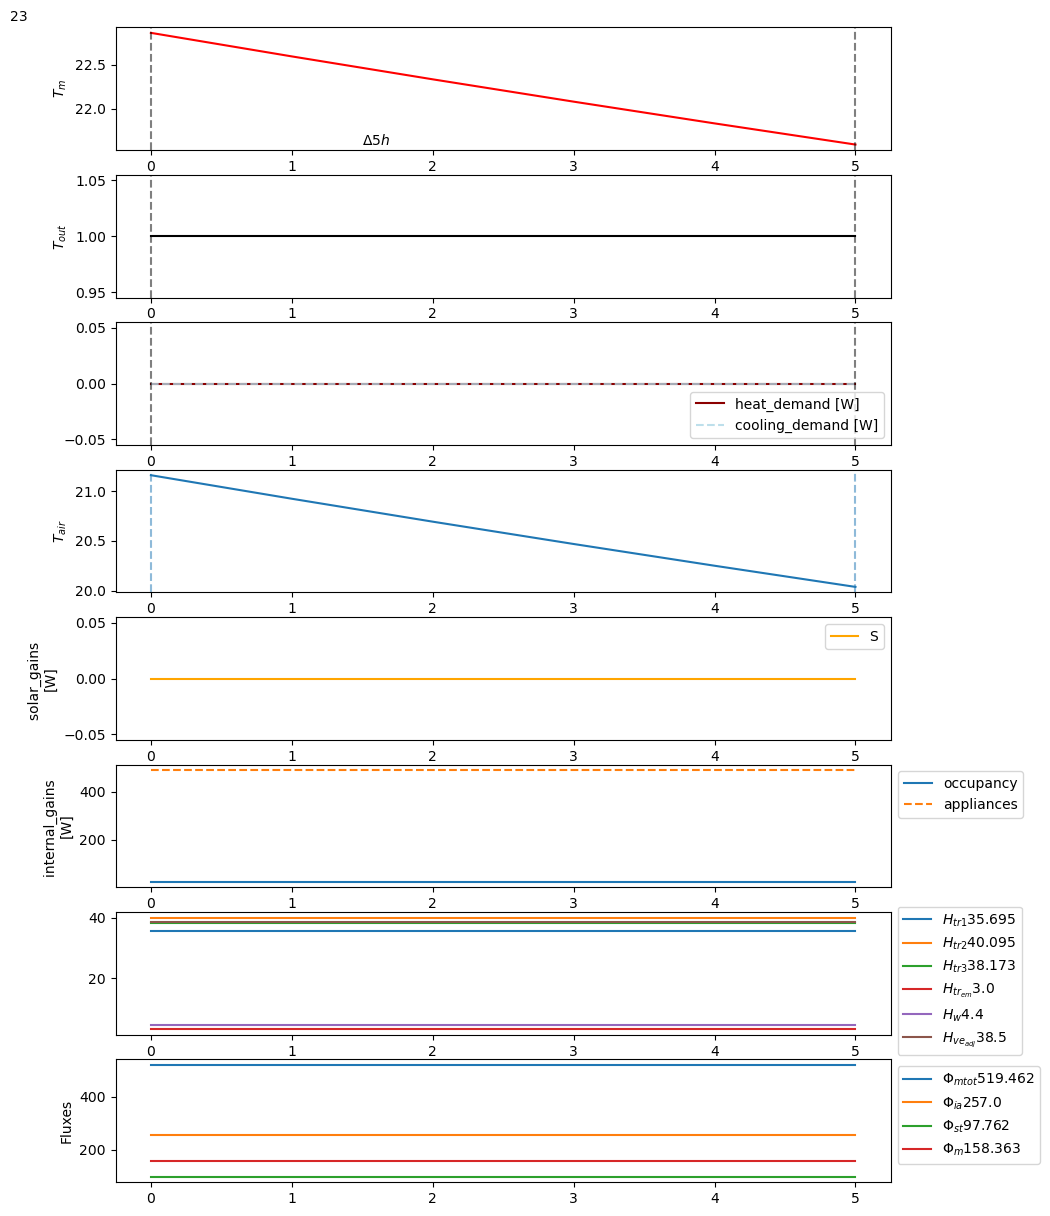

In [1200]:
fig, ax = plt.subplots(8,1, figsize=(10,15))

ax[0].plot(x, t_ms, c="r")
ax[0].set_ylabel("$T_m$")
ax[0].axvline(t_start_cooling, linestyle="--", alpha=0.5, c="k")
ax[0].axvline(t_end_cooling, linestyle="--", alpha=0.5, c="k")
ax[0].text((t_start_cooling + t_end_cooling)/2-1, min(t_ms), f"$\Delta {delta_t}h$")
ax[0].text(-1,t_m_0, f"{t_m_0}")

ax[1].plot(x, t_outs, c="k")
ax[1].set_ylabel("$T_{out}$")
ax[1].axvline(t_start_cooling, linestyle="--", alpha=0.5, c="k")
ax[1].axvline(t_end_cooling, linestyle="--", alpha=0.5, c="k")

ax[2].plot(x, heating_demands, c="darkred", label="heat_demand [W]")
ax[2].plot(x, cooling_demands, c="lightblue", linestyle="--", alpha=0.8, label="cooling_demand [W]")
ax[2].axvline(t_start_cooling, linestyle="--", alpha=0.5, c="k")
ax[2].axvline(t_end_cooling, linestyle="--", alpha=0.5, c="k")
ax[2].legend(loc="lower right")

ax[3].plot(x, t_airs)
ax[3].set_ylabel("$T_{air}$")
ax[3].axvline(t_start_cooling, linestyle="--", alpha=0.5)
ax[3].axvline(t_end_cooling, linestyle="--", alpha=0.5)

ax[4].plot(x, solar_gains_, label="S", c="orange")
ax[4].set_ylabel("solar_gains \n[W]")
ax[4].legend()

ax[5].plot(x, person_occupancies, label="occupancy")
ax[5].plot(x, appliance_gains_, label="appliances", linestyle="--")
ax[5].set_ylabel("internal_gains \n[W]")
ax[5].legend(loc="upper right", bbox_to_anchor=(1.18, 1))

ax[6].plot(x, h_tr_1s, label=f"$H_{{tr1}} {np.round(h_tr_1s[0],3)}$")
ax[6].plot(x, h_tr_2s, label=f"$H_{{tr2}} {np.round(h_tr_2s[0],3)}$")
ax[6].plot(x, h_tr_3s, label=f"$H_{{tr3}} {np.round(h_tr_3s[0],3)}$")
ax[6].plot(x, h_tr_ems, label=f"$H_{{tr_{{em}}}} {np.round(h_tr_ems[0],3)}$")
ax[6].plot(x, h_ws, label=f"$H_{{w}} {np.round(h_ws[0],3)}$")
ax[6].plot(x, h_ves, label=f"$H_{{ve_{{adj}}}} {np.round(h_ves[0],3)}$")
ax[6].legend(loc="best",bbox_to_anchor=(1, 1.1))

ax[7].plot(x, phi_m_tots, label=f"$\Phi_{{mtot}} {np.round(phi_m_tots[0],3)}$")
ax[7].set_ylabel("Fluxes")

#ax[8].plot(x, h_ws, label=f"$H_{{w}} {np.round(h_ws[0],3)}$")
#ax[8].legend(loc="best")

ax[7].plot(x, phi_ias, label=f"$\Phi_{{ia}} {np.round(phi_ias[0],3)}$")
ax[7].plot(x, phi_sts, label=f"$\Phi_{{st}} {np.round(phi_sts[0],3)}$")
ax[7].plot(x, phi_ms, label=f"$\Phi_{{m}} {np.round(phi_ms[0],3)}$")
ax[7].legend(loc="best", bbox_to_anchor=(1, 1))

## Extracting parameters from the 5R1C model
---

In [1083]:
Te = t_out
print("Te:", Te)

phi_int = internal_gains_[0]
print("phi_int:", phi_int)

phi_ia = phi_ias[0]
print("phi_ia:", phi_ia)

phi_m = phi_ms[0]
print("phi_m:", phi_m)

phi_st = phi_sts[0]
print("phi_st: ", phi_st)

C = phi_ia
print("C:", C)

A_m = Office.floor_area*2.5
print("A_m: ", A_m)

A_t = Office.A_t
print("A_t: ", A_t)

C1 = (A_m/A_t)*C
print("C1:", C1)

h_tr1 = h_tr_1s[0]
print("h_tr1:", h_tr1)

h_tr2 = h_tr_2s[0]
print("h_tr2:", h_tr2)

h_tr3 = h_tr_3s[0]
print("h_tr3:", h_tr3)

h_em = h_tr_ems[0]
print("h_em:", h_em)

h_w = h_ws[0]
print("h_w:", h_w)

h_ve = h_ves[0]
print("h_ve:", h_ve)

C_m = Office.c_m
print("C_m:", C_m)

Te: 1
phi_int: 514.0
phi_ia: 257.0
phi_m: 158.36267605633802
phi_st:  97.76222720941031
C: 257.0
A_m:  87.5
A_t:  142.0
C1: 158.36267605633802
h_tr1: 35.69483345950038
h_tr2: 40.09483345950038
h_tr3: 38.17266498803948
h_em: 3.0
h_w: 4.4
h_ve: 38.5
C_m: 5600000.0


### Total heat flux $\Phi_{mtot} = ?$

In [1153]:
phi_m_tot = phi_m + h_em * t_out + \
            h_tr3 * (phi_st + h_w * t_out + h_tr1 *
                           ((phi_ia / h_ve) + t_out)) / h_tr2
phi_m_tot

519.4623795221543

\begin{equation}
T_m(H_{tr3} + H_{em}) + C_m\frac{dT_m}{dt} = \Phi_{mtot}
\end{equation} 

$$
\rightarrow \frac{dT_m}{dt} = \frac{1}{C_m}\left(\Phi_{m_{tot}} - (H_{tr3} + H_{em}) \cdot T_m\right) 
$$
with:  $$T_m(0) = 24$$

$$\Phi_{mtot} = \frac{A_m}{A_t}\cdot0.5\cdot\Phi_{int} + H_{em}T_e + \frac{H_{tr3}}{H_w + H_{tr1}}\left((1 - \frac{A_m}{A_t} - \frac{H_w}{9.1\cdot A_t})\cdot0.5\cdot\Phi_{int} + T_e\cdot (H_w + H_{tr1}) +  \frac{H_{tr1}}{H_{ve}}\cdot0.5\cdot\Phi_{int})\right)$$

where: 
$$H_{tr1} = 35.69483345950038$$
$$H_{tr2} = 40.09483345950038$$
$$H_{tr3} = 38.17266498803948$$
$$H_{em} = 3.0$$
$$H_{ve} = 38.5$$
$$H_w = 4.4$$
$$\Phi_{int} = 514.0$$
$$T_e = 1.0$$

$$A_m = \text{mass_area}\rightarrow A_m = \text{floor_area} · 2.5 \rightarrow A_m = 35.0 \cdot 2.5 \rightarrow A_m= 87.5$$<br>
$$A_t = \text{total_internal_area} = 142.0$$<br>

In [1152]:
phi_m_tot = (A_m/A_t)*0.5*phi_int + h_em * t_out + \
            (h_tr3/(h_w + h_tr1)) * ((1-(A_m/A_t) - (h_w/(9.1*A_t)))*0.5*phi_int + t_out*(h_w + h_tr1) + \
                           (h_tr1/h_ve)*0.5*phi_int)
print(phi_m_tot)

519.4623795221543


### Defining Neural ODE
---

In [1033]:
class Lambda(nn.Module):
    def __init__(self, h_tr1, h_tr2, h_tr3, h_em, h_w, h_ve, A_m, A_t, Te, phi_int, C_m):
        super(Lambda, self).__init__()

        self.h_tr1 = nn.Parameter(h_tr1)
        self.h_tr2 = nn.Parameter(h_tr2)
        self.h_tr3 = nn.Parameter(h_tr3)
        self.h_em = nn.Parameter(h_em)
        self.h_w = nn.Parameter(h_w)
        self.h_ve = nn.Parameter(h_ve)
        self.A_m = nn.Parameter(A_m)
        self.A_t = nn.Parameter(A_t)
        self.Te = Te
        self.phi_int = phi_int
        self.C_m = nn.Parameter(C_m)
        self.phi_mtots = []
        
    def forward(self, t, x):
        phi_m_tot = (self.A_m / self.A_t) * 0.5 * self.phi_int + self.h_em * self.Te + \
                (self.h_tr3 / (self.h_w + self.h_tr1)) * ((1 - (self.A_m / self.A_t) - \
                    (self.h_w / (9.1 * self.A_t))) * 0.5 * self.phi_int + self.Te * (self.h_w + self.h_tr1) + \
                        (self.h_tr1 / self.h_ve) * 0.5 * self.phi_int)
        #phi_mtot = 519.4 #[W]
        self.phi_mtots.append(phi_m_tot)
        return (1/self.C_m)*3600*(phi_m_tot -(self.h_tr3 + self.h_em)*x)

In [1034]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [1113]:
def visualize(true_y, pred_y, odefunc, itr, current_loss=None, lr=None, 
              true_params=None, predicted_params=None, initial_params=None, true_params_=None,
             batch_t = None, batch_y=None):
    
        fig = plt.figure(figsize=(12, 8), facecolor='white')
        
        ax_traj = fig.add_subplot(111, frameon=False)
        
        #ax_phase = fig.add_subplot(222, frameon=False)
        if true_params is not None:
            
            rel_errs = [str(np.round((np.abs(predicted_params[i] - true_params[i])*100/np.abs(true_params[i])).item(),2).item())+"%" 
                        for i in predicted_params]
        else:
            rel_errs = predicted_params
        
        predicted_params_ = [np.round(predicted_params[i].item(),2) for i in predicted_params]
        

        
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x')
        ax_traj.scatter(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], label="$y$", c="k", alpha=0.1)
        ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', c="r",
                    label='Iter {:04d} \nTotal Loss {:.6f} \nlr {:.6f} \n$\hat{{θ}}$(0):{} \n$\hat{{θ}}$:{}  \n$θ_{{true}}$:{}  \nRE_{{θ}} {}'.format(itr, 
                                                                                                                                current_loss, 
                                                                                                                                lr,
                                                                                                                                initial_params,
                                                                                                                                predicted_params_,
                                                                                                                                true_params_,
                                                                                                                                rel_errs))
        #print(len(batch_t.flatten()))
        #print(len(batch_y[0].flatten()))
        #ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        #ax_traj.scatter(batch_t.flatten(), batch_y[0].flatten())
    
        
        # Show the plot
        plt.tight_layout()
        # Add a general legend below the subplots
        fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fontsize=15)
        plt.grid()
        plt.show()

In [1114]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args["data_size"] - args["batch_time"], dtype=np.int64), args["batch_size"], replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args["batch_time"]]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args["batch_time"])], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

### Defining training parameters
---

In [1115]:
args = {
    'method': 'dopri5',
    'data_size': 100,
    'batch_time': 10,
    'batch_size': 10,
    'niters': 1000,
    'test_freq': 20,
    'viz': False,  # Change to True if visualization is needed
    'gpu': 0,
    'adjoint': True  # Change to True if using adjoint method
}

if args['adjoint']:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args['gpu']) if torch.cuda.is_available() else 'cpu')

#### Defining true model parameters again and checking if phi_m_tot holds true

In [1154]:
Te = t_out
phi_int = internal_gains_[0]
phi_ia = phi_ias[0]
phi_m = phi_ms[0]
phi_st = phi_sts[0]
C = phi_ia
A_m = Office.floor_area * 2.5
A_t = Office.A_t
C1 = (A_m / A_t) * C
h_tr1 = h_tr_1s[0]
h_tr2 = h_tr_2s[0]
h_tr3 = h_tr_3s[0]
h_em = h_tr_ems[0]
h_w = h_ws[0]
h_ve = h_ves[0]
C_m = Office.c_m
phi_m_tot = (A_m/A_t)*0.5*phi_int + h_em * t_out + \
            (h_tr3/(h_w + h_tr1)) * ((1-(A_m/A_t) - (h_w/(9.1*A_t)))*0.5*phi_int + Te*(h_w + h_tr1) + \
                           (h_tr1/h_ve)*0.5*phi_int)
print(phi_m_tot)

519.4623795221543


### Initializing parameters with normal distributions N~(true_value, std)
---

In [1175]:
std = 20

h_tr1_ = nn.init.normal_(torch.empty(1,1), mean=h_tr1, std=std)  # mean =  35.6948
h_tr2_ = nn.init.normal_(torch.empty(1,1), mean=h_tr2, std=std)  # mean =  40.0948
h_tr3_ = nn.init.normal_(torch.empty(1,1), mean=h_tr3, std=std)  # mean =  38.1727
h_em_ = nn.init.normal_(torch.empty(1,1), mean=h_em, std=2)  # mean =  3.
h_w_ = nn.init.normal_(torch.empty(1,1), mean=h_w, std=2)  # mean =  4.4000
h_ve_ = nn.init.normal_(torch.empty(1,1), mean=h_ve, std=std)  # mean =  38.5000
A_m_ = nn.init.normal_(torch.empty(1,1), mean=A_m, std=60)  # floor_area·2.5 ---> mean =  87.5000
A_t_ = nn.init.normal_(torch.empty(1,1), mean=A_t, std=100)  # mean =  142.
C_m_ = nn.init.normal_(torch.empty(1,1), mean=C_m, std=3000000)  # mean =  5600000.

#define initial temperature
true_y0 = torch.tensor([[23.]]).to(device)

#define time range
t = torch.linspace(0., 6., args['data_size']).to(device)
#t = torch.linspace(0., 7, args["data_size"]).to(device)
#t = torch.arange(0., 7.).to(device)

### Define true ODE and randomly initialized ODE
---

In [1176]:
true_ode = Lambda(Tensor([[h_tr1]]) ,Tensor([[h_tr2]]), Tensor([[h_tr3]]), Tensor([[h_em]]), 
                  Tensor([[h_w]]), Tensor([[h_ve]]), Tensor([[A_m]]), Tensor([[A_t]]), Tensor([[Te]]),
                  Tensor([[phi_int]]),Tensor([[C_m]]))

ode_func = Lambda(h_tr1_, h_tr2_, h_tr3_, h_em_, h_w_, h_ve_, A_m_, A_t_, Te, phi_int, C_m_).to(device)

true_ode.state_dict(), ode_func.state_dict()

(OrderedDict([('h_tr1', tensor([[35.6948]])),
              ('h_tr2', tensor([[40.0948]])),
              ('h_tr3', tensor([[38.1727]])),
              ('h_em', tensor([[3.]])),
              ('h_w', tensor([[4.4000]])),
              ('h_ve', tensor([[38.5000]])),
              ('A_m', tensor([[87.5000]])),
              ('A_t', tensor([[142.]])),
              ('C_m', tensor([[5600000.]]))]),
 OrderedDict([('h_tr1', tensor([[59.8000]])),
              ('h_tr2', tensor([[18.8694]])),
              ('h_tr3', tensor([[50.7713]])),
              ('h_em', tensor([[4.9930]])),
              ('h_w', tensor([[5.7532]])),
              ('h_ve', tensor([[41.0085]])),
              ('A_m', tensor([[3.8332]])),
              ('A_t', tensor([[160.6423]])),
              ('C_m', tensor([[5437192.5000]]))]))

### Solving ODE with true parameters
---

In [1177]:
with torch.no_grad():
    true_y = odeint(true_ode, true_y0, t, method='dopri5')

#### Plotting temperatures obtained with solving true ODE and those from the model
---

In [1178]:
true_y_ = true_y.flatten().numpy()

In [1179]:
t_ms_ = np.array([t_m_0] + t_ms)

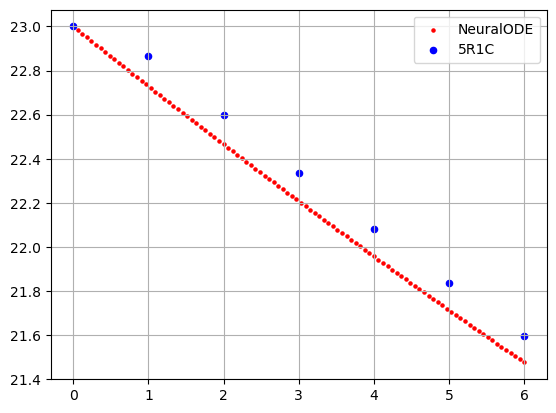

In [1180]:
x_ = x + [max(x)+1]
plt.scatter(t, true_y_, label="NeuralODE", c="r", s=5)
plt.scatter(x_, t_ms_, label="5R1C", c="b", s=20)
plt.legend()
plt.grid()

pretty good!

### Interpolating 100 points for model temperature observations
---

In [1181]:
from scipy.interpolate import interp1d

# Given data points
x_ = [0, 1, 2, 3, 4, 5, 6]
t_ms_ = [23.0, 22.86438121, 22.59668632, 22.33598427, 22.0820924, 21.8348328, 21.59403222]

# Create an interpolation function
interp_func = interp1d(x_, t_ms_, kind='linear')

# Generate 100 evenly spaced points
x_interpolated = np.linspace(min(x_), max(x_), 100)
t_ms_interpolated = interp_func(x_interpolated)

# Now, x_interpolated contains the 100 interpolated points, and t_ms_interpolated contains their corresponding values

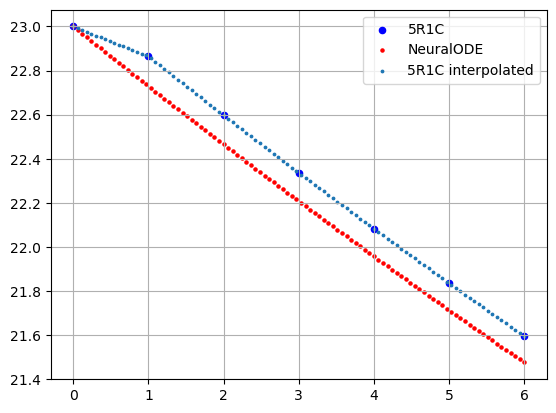

In [1182]:
plt.scatter(x_, t_ms_, label="5R1C", c="b", s=20)
plt.scatter(t, true_y_, label="NeuralODE", c="r", s=5)
plt.scatter(x_interpolated, t_ms_interpolated, s=3, label="5R1C interpolated")
plt.legend()
plt.grid()

In [1183]:
t_ms_interpolated_torch = Tensor(t_ms_interpolated).view(-1,1,1)

Here we can decide whether to train Neural ODE on interpolated model temperature obeservations or on the observations obtained from Neural ODE forward pass with true parameters. Uncomment the below cell in case of the first option. 

In [1184]:
#true_y = t_ms_interpolated_torch

## Training Neural ODE
---

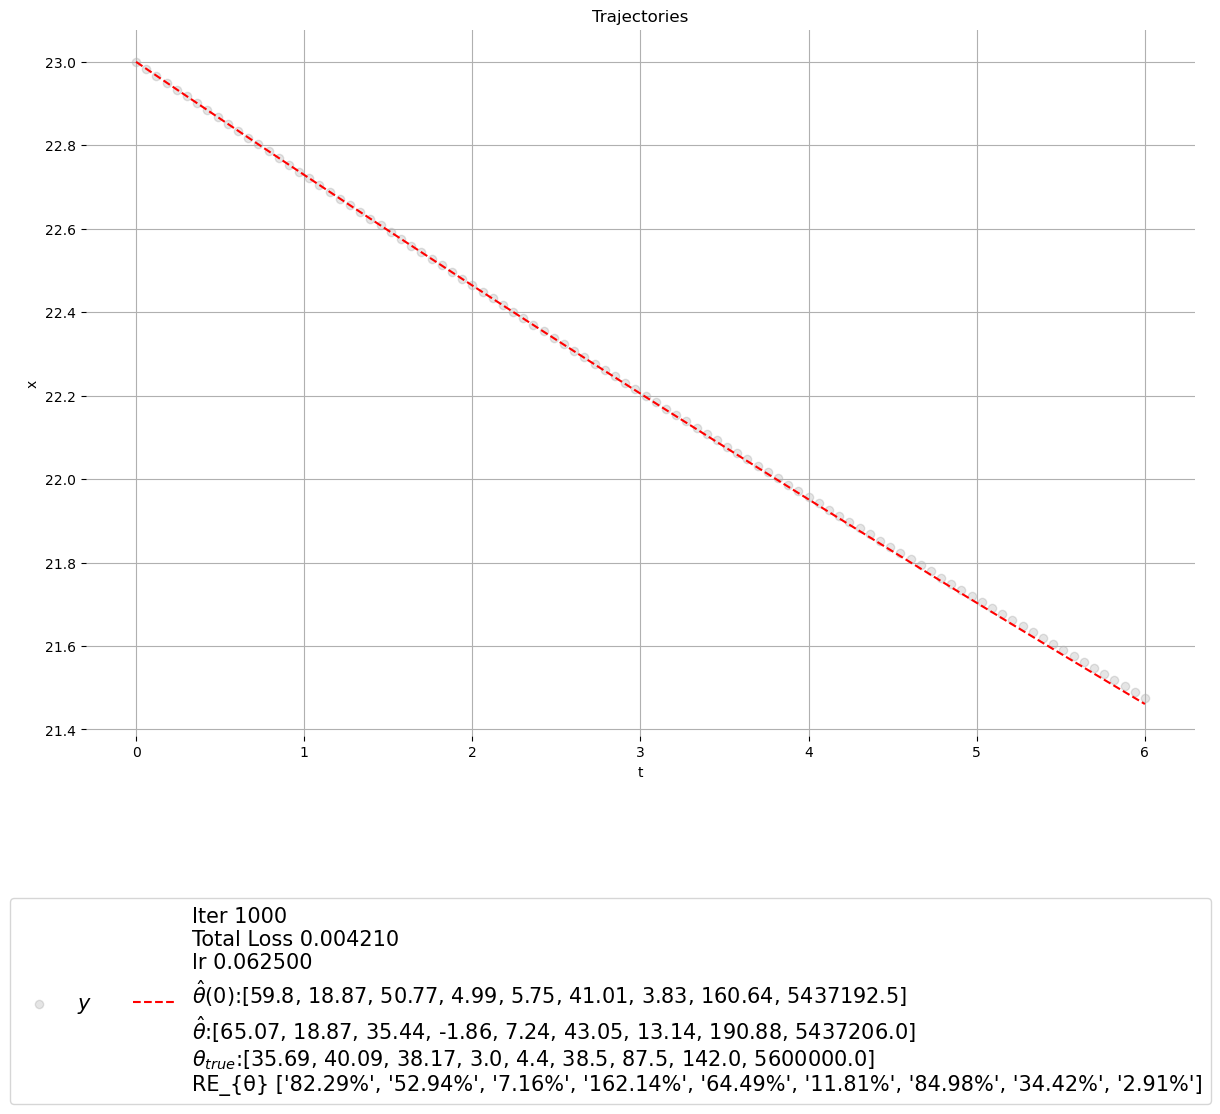

In [1185]:
true_params = true_ode.state_dict()
true_params_ = [np.round(true_params[i].item(),2) for i in true_params]

initial_params = ode_func.state_dict()
initial_params = [np.round(initial_params[i].item(),2) for i in initial_params]

ii = 0
optimizer = optim.RMSprop(ode_func.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)


for itr in range(1, args["niters"] + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    #print(batch_t)
    #print(batch_y[0])
    pred_y = odeint(ode_func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    
    predicted_params = ode_func.state_dict()
    
    lr = optimizer.param_groups[0]['lr']

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % args["test_freq"] == 0:
        with torch.no_grad():
            pred_y = odeint(ode_func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, ode_func, itr, current_loss = loss, lr = lr,
                      true_params=true_params, predicted_params = predicted_params, 
                      initial_params = initial_params,
                      true_params_ = true_params_, 
                      batch_t = batch_t, batch_y=batch_y)
            ii += 1
        clear_output(wait=True)
    
    optimizer.step()
    if scheduler is not None: 
            scheduler.step()

### Relative errors
---

In [1187]:
predicted_params = ode_func.state_dict()

rel_errs = [str(np.round((np.abs(predicted_params[i] - true_params[i])*100/np.abs(true_params[i])).item(),2).item())+"%" 
                        for i in predicted_params]
print(rel_errs)

['81.89%', '52.94%', '7.53%', '166.86%', '61.22%', '11.44%', '84.82%', '34.32%', '2.91%']


### Extracting learned parameters
---

In [1188]:
ode_func.state_dict()

OrderedDict([('h_tr1', tensor([[64.9248]])),
             ('h_tr2', tensor([[18.8694]])),
             ('h_tr3', tensor([[35.2993]])),
             ('h_em', tensor([[-2.0057]])),
             ('h_w', tensor([[7.0937]])),
             ('h_ve', tensor([[42.9040]])),
             ('A_m', tensor([[13.2801]])),
             ('A_t', tensor([[190.7342]])),
             ('C_m', tensor([[5437206.]]))])

### Calculate $\Phi_{mtot}$ with learned parameters and compare it to true value
---

In [1189]:
phi_m_tot = (A_m/A_t)*0.5*phi_int + h_em * t_out + \
            (h_tr3/(h_w + h_tr1)) * ((1-(A_m/A_t) - (h_w/(9.1*A_t)))*0.5*phi_int + t_out*(h_w + h_tr1) + \
                           (h_tr1/h_ve)*0.5*phi_int)
print(phi_m_tot)

519.4623795221543


In [1190]:
def calculate_phi_m_tot(inputs, phi_int, Te):
    # Extract values from the dictionary
    A_m = inputs['A_m'].item()
    A_t = inputs['A_t'].item()
    h_em = inputs['h_em'].item()
    h_tr1 = inputs['h_tr1'].item()
    h_tr3 = inputs['h_tr3'].item()
    h_w = inputs['h_w'].item()
    h_ve = inputs['h_ve'].item()
    phi_int = phi_int  # Assuming this value is already a numeric type
    t_out = Te  # Assuming this value is already a numeric type

    # Calculate phi_m_tot
    phi_m_tot = (A_m / A_t) * 0.5 * phi_int + h_em * t_out + \
                (h_tr3 / (h_w + h_tr1)) * ((1 - (A_m / A_t) - (h_w / (9.1 * A_t))) * 0.5 * phi_int + t_out * (h_w + h_tr1) + \
                (h_tr1 / h_ve) * 0.5 * phi_int)

    return phi_m_tot

In [1191]:
# Calculate phi_m_tot
phi_m_tot_learned = calculate_phi_m_tot(ode_func.state_dict(), phi_int, Te)
print("phi_m_tot_learned: ",phi_m_tot_learned)
print("phi_m_tot_true:", phi_m_tot)

phi_m_tot_learned:  358.4885606172802
phi_m_tot_true: 519.4623795221543


In [1192]:
ode_func.state_dict()

OrderedDict([('h_tr1', tensor([[64.9248]])),
             ('h_tr2', tensor([[18.8694]])),
             ('h_tr3', tensor([[35.2993]])),
             ('h_em', tensor([[-2.0057]])),
             ('h_w', tensor([[7.0937]])),
             ('h_ve', tensor([[42.9040]])),
             ('A_m', tensor([[13.2801]])),
             ('A_t', tensor([[190.7342]])),
             ('C_m', tensor([[5437206.]]))])

### Calculate temperature behaviour with learned 5R1C
---

In [1193]:
def calc_t_m_next(t_m_prev, inputs, phi_int, Te):
        
        """
        Primary Equation, calculates the temperature of the next time step
        # (C.4) in [C.3 ISO 13790]
        """
        h_tr_3 = inputs['h_tr3'].item()
        h_tr_em = inputs['h_em'].item()
        c_m = inputs['C_m'].item()
        
        phi_m_tot = calculate_phi_m_tot(inputs, phi_int, Te)
        
        
        t_m_next = ((t_m_prev * ((c_m / 3600.0) - 0.5 * (h_tr_3 + h_tr_em))) +
                         phi_m_tot) / ((c_m / 3600.0) + 0.5 * (h_tr_3 + h_tr_em))
        return t_m_next

In [1194]:
def calc_t_m(t_m_prev, inputs, phi_int, Te):
        """
        Temperature used for the calculations, average between newly calculated and previous bulk temperature
        # (C.9) in [C.3 ISO 13790]
        """
        t_m_next = calc_t_m_next(t_m_prev, inputs, phi_int, Te)
        t_m = (t_m_next + t_m_prev) / 2.0
        return t_m

In [1195]:
t_m_prev = 23.
inputs = ode_func.state_dict()

t_MM = [t_m_prev]
for i in range(6):
    t_MM.append(calc_t_m(t_m_prev, inputs, phi_int, Te))
    t_m_prev = calc_t_m_next(t_m_prev, inputs, phi_int, Te)
print(t_MM)

[23.0, 22.866643781466664, 22.60283898429435, 22.34478607001897, 22.092359627134673, 21.845436978552534, 21.603898121980492]


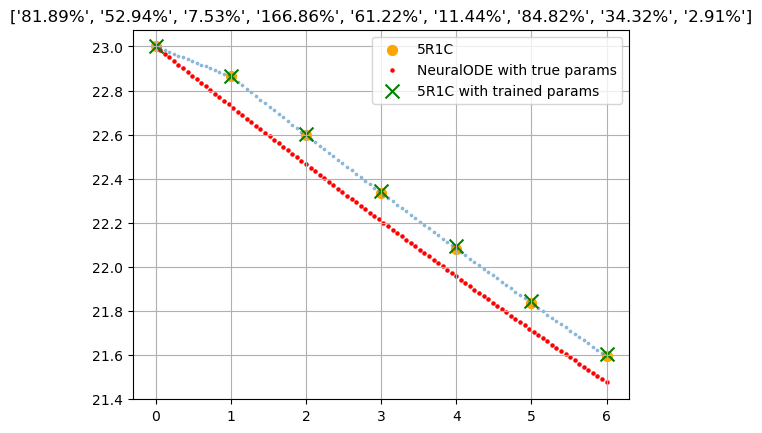

In [1198]:
plt.scatter(x_, t_ms_, label="5R1C", c="orange", s=50)
plt.scatter(t, true_y_, label="NeuralODE with true params", c="r", s=5)
plt.scatter(x_interpolated, t_ms_interpolated, s=3, alpha=0.4)
plt.scatter(x_, t_MM, s=100, c="g", marker="x", label="5R1C with trained params")
plt.title(f"{rel_errs}")
plt.legend()
plt.grid()

pretty good!